In [2]:
%matplotlib inline

In [5]:
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
# imageio.plugins.ffmpeg.download()

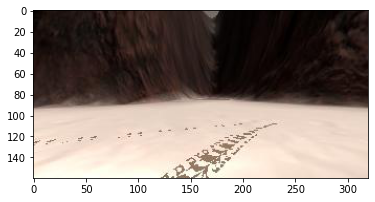

In [6]:
path = '/home/shaxpy/Desktop/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
img = mpimg.imread(img_list[idx])
plt.imshow(img)

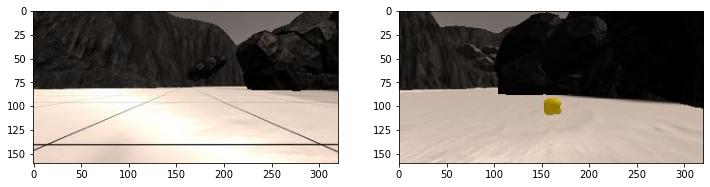

In [7]:
example_grid = '/home/shaxpy/Downloads/Search and Sample bot/calib/5.jpg'
example_rock = '/home/shaxpy/Downloads/Search and Sample bot/calib/rock.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

In [8]:
def perspect_transform(img,src,dst):
    m=cv2.getPerspectiveTransform(src,dst)
    warped=cv2.warpPerspective(img,m,(img.shape[1],img.shape[0]))
    return warped

# Perform warping and color thresholding
##########

# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
sze=5
# Bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom=6
source=np.float32([[14,139],[301,140],[200,96],[118,96]])
dest=np.float32([[img.shape[1]/2-sze,img.shape[0]-bottom],
                 [img.shape[1]/2+sze,img.shape[0]-bottom],
                 [img.shape[1]/2+sze,img.shape[0]- 2*sze-bottom],
                 [img.shape[1]/2-sze,img.shape[0]- 2*sze-bottom],])




def color_thresh(img, rgb_thresh=(0, 0, 0)):
    color_select = np.zeros_like(img[:,:,0])
    above= (img[:,:,0]>rgb_thresh[0])             & (img[:,:,1] > rgb_thresh[1])             & (img[:,:,2] > rgb_thresh[2])
    color_select[above] = 1
    return color_select
warped=perspect_transform(img,source,dest)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
# Define color selection criteria
red_threshold = 160
green_threshold = 160
blue_threshold = 160
######
rgb_threshold = (red_threshold, green_threshold, blue_threshold)

#Rover centric coordinate from image

def rover_coords(binary_img):
    # Extract xpos and ypos pixel positions from binary_img and
    ypos, xpos = binary_img.nonzero()
    # Convert xpos and ypos to rover-centric coordinates
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel
xpix, ypix = rover_coords(colorsel)


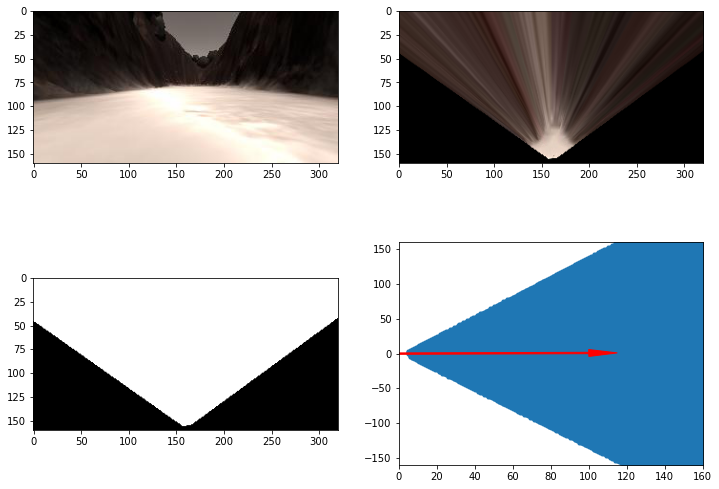

In [9]:

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

In [10]:
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('/home/shaxpy/Desktop/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('/home/shaxpy/Downloads/Search and Sample bot/calib/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


In [11]:
print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

100.5299 85.54301 263.1323


## Func to extract position and yaw from csv
### Process image to create output video

In [12]:
# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, dest)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make video

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '/home/shaxpy/Desktop/output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

t:   1%|          | 14/1512 [00:00<00:11, 135.75it/s, now=None]

Moviepy - Building video /home/shaxpy/Desktop/output/test_mapping.mp4.
Moviepy - Writing video /home/shaxpy/Desktop/output/test_mapping.mp4



Moviepy - Done !
Moviepy - video ready /home/shaxpy/Desktop/output/test_mapping.mp4
CPU times: user 19.8 s, sys: 4.31 s, total: 24.1 s
Wall time: 16.5 s
